In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium

In [3]:
train_data = pd.read_csv("data/train.csv")
bst_data = pd.read_csv("data/metadata.csv")

In [4]:
bst_data

,grupo,btsId,btsNetNome,lat,lon,cch,azimuth,RssiId
0,1,BTS_1_1,PEMDL01_1,-8.04342,-34.952000,873,0,rssi_1_1
1,1,BTS_1_2,PEMDL01_2,-8.04342,-34.952000,872,120,rssi_1_2
2,1,BTS_1_3,PEMDL01_3,-8.04342,-34.952000,875,240,rssi_1_3
3,2,BTS_2_1,PEMDL08_1,-8.05289,-34.944672,865,0,rssi_2_1
4,2,BTS_2_2,PEMDL08_2,-8.05289,-34.944672,874,120,rssi_2_2
5,2,BTS_2_3,PEMDL08_3,-8.05289,-34.944672,871,240,rssi_2_3
6,3,BTS_3_1,PEMDL09_1,-8.05532,-34.957900,877,0,rssi_3_1
7,3,BTS_3_2,PEMDL09_2,-8.05532,-34.957900,881,120,rssi_3_2
8,3,BTS_3_3,PEMDL09_3,-8.05532,-34.957900,869,240,rssi_3_3


,ponto_id,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,lat,lon,indoor
0,6604,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.0000,5.0,3.0,2.0,-8.055786,-34.951505,True
1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.1200,5.0,3.0,2.0,-8.055784,-34.951608,True
2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.0000,5.0,3.0,2.0,-8.055506,-34.951693,True
3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.2700,4.0,7.0,2.0,-8.050390,-34.959630,False
4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.0000,5.0,3.0,2.0,-8.055380,-34.951736,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6770,5734,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-93.005000,-97.114286,-108.1200,5.0,3.0,2.0,-8.055784,-34.951608,True
6771,5191,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-87.315000,-88.735714,-108.1200,5.0,3.0,2.0,-8.055784,-34.951608,True
6772,5390,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-95.165000,-90.705714,-108.1200,5.0,3.0,2.0,-8.055784,-34.951608,True
6773,860,-109.088333,-107.200000,-107.010000,-108.430000,-97.200000,-98.148571,-99.840000,-94.665000,-115.0000,5.0,3.0,2.0,-8.055380,-34.951736,True


In [5]:
COLUMN_NAMES = ["rssi_1_1", "rssi_1_2", "rssi_1_3", "rssi_2_1", "rssi_2_2", "rssi_2_3", "rssi_3_1", "rssi_3_2", "rssi_3_3"]
train_data['Max'] = train_data[COLUMN_NAMES].abs().idxmax(axis=1)

In [9]:
train_data = train_data.merge(bst_data[["RssiId", "grupo", "lat", "lon"]], left_on="Max", right_on="RssiId", how="left")

In [12]:
train_data

,ponto_id,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,...,indoor,Max,RssiId_x,grupo_x,lat_y,lon_y,RssiId_y,grupo_y,lat,lon
0,6604,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.0000,...,True,rssi_3_3,rssi_3_3,3,-8.05532,-34.9579,rssi_3_3,3,-8.05532,-34.9579
1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.1200,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.0000,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.2700,...,False,rssi_3_2,rssi_3_2,3,-8.05532,-34.9579,rssi_3_2,3,-8.05532,-34.9579
4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.0000,...,True,rssi_3_3,rssi_3_3,3,-8.05532,-34.9579,rssi_3_3,3,-8.05532,-34.9579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6770,5734,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-93.005000,-97.114286,-108.1200,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
6771,5191,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-87.315000,-88.735714,-108.1200,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
6772,5390,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-95.165000,-90.705714,-108.1200,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
6773,860,-109.088333,-107.200000,-107.010000,-108.430000,-97.200000,-98.148571,-99.840000,-94.665000,-115.0000,...,True,rssi_3_3,rssi_3_3,3,-8.05532,-34.9579,rssi_3_3,3,-8.05532,-34.9579


In [23]:
output = train_data[["ponto_id", "lat", "lon"]]
output

,ponto_id,lat,lon
0,6604,-8.05532,-34.9579
1,5515,-8.04342,-34.9520
2,5049,-8.04342,-34.9520
3,8737,-8.05532,-34.9579
4,1203,-8.05532,-34.9579
...,...,...,...
6770,5734,-8.04342,-34.9520
6771,5191,-8.04342,-34.9520
6772,5390,-8.04342,-34.9520
6773,860,-8.05532,-34.9579


In [24]:
output.to_csv("Resultado_Equipe1_MetodoProximidade", index=False)

In [25]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371e3 # em metros
    phi1 = lat1 * math.pi/180 # Radianos
    phi2 = lat2 * math.pi/180

    delta_phi = (lat2-lat1) * math.pi/180 # Radianos
    delta_lambda = (lon2 - lon1) * math.pi/180

    a = np.sin(delta_phi/2.)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return c * R

In [26]:
def plot_histogram_errors(lat_pred, lon_pred, lat_real, lon_real):
    dist = haversine_distance(lat_pred, lon_pred, lat_real, lon_real)

    with sns.plotting_context():
        sns.set(rc={'figure.figsize':(17.7,8.27)})
        ax = sns.histplot(dist, kde=True, bins=100)
        ax.set_xticks(range(0,1750, 50))
        ax.set(xlabel='Errors')
        plt.show()

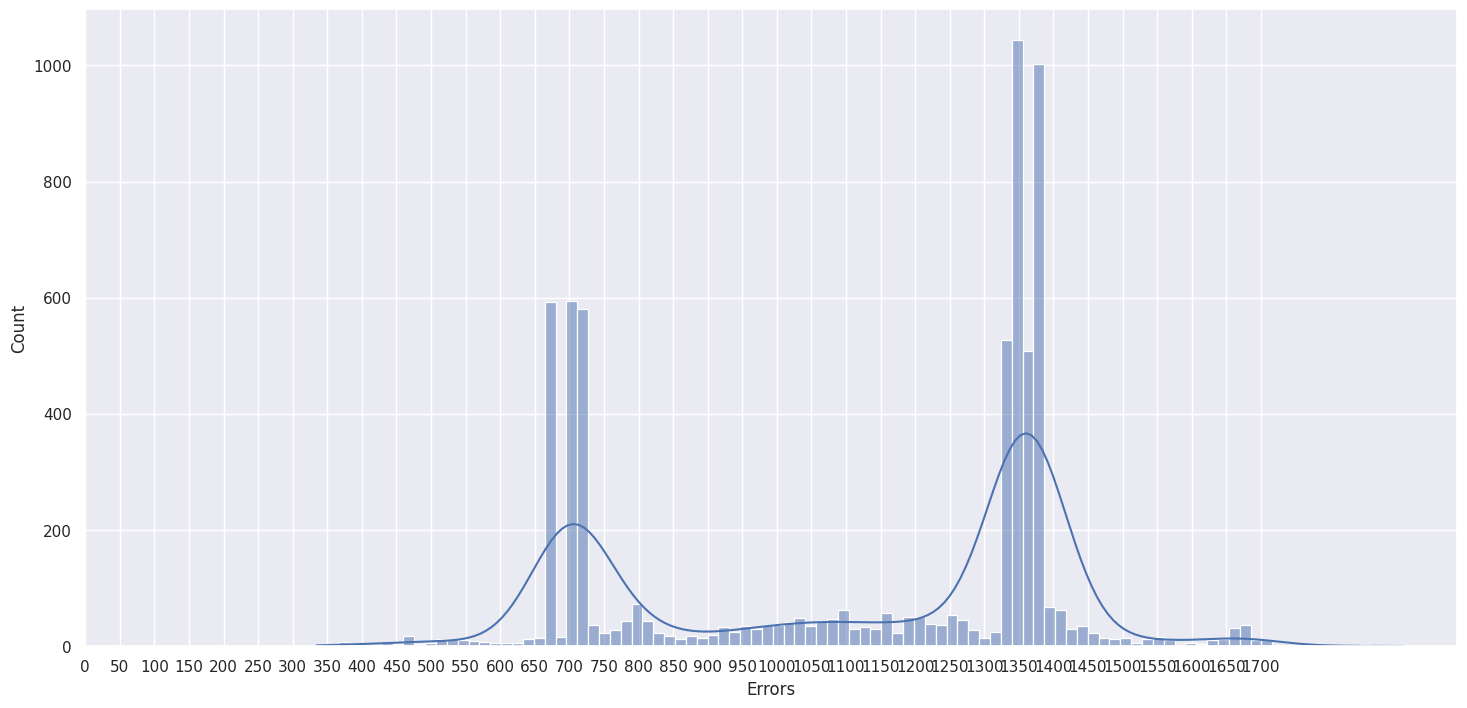

In [81]:
plot_histogram_errors(output["lat"], output["lon"], train_data["lat_x"], train_data["lon_x"])


In [28]:
def plot_boxplot_errors(lat_pred, lon_pred, lat_real, lon_real):
    dist = haversine_distance(lat_pred, lon_pred, lat_real, lon_real)

    with sns.plotting_context():
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        ax=sns.boxplot(dist)
        ax.set(ylabel='Errors')
        plt.show()

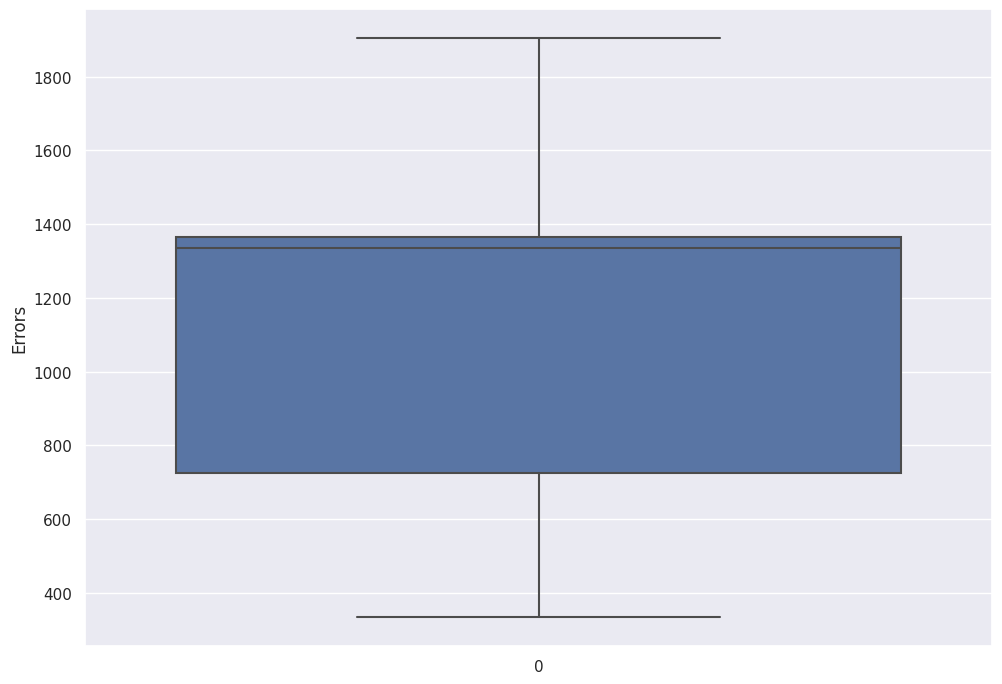

In [82]:
plot_boxplot_errors(output["lat"], output["lon"], train_data["lat_x"], train_data["lon_x"])


In [52]:
def plot_map_coordinates(lat_pred, lon_pred, lat_real, lon_real):
    ufpe_lat = -8.05055754239243
    ufpe_lon = -34.95075894852773

    map=folium.Map(location=[ufpe_lat,ufpe_lon])

    for i in range(len(lat_pred)):
        map.add_child(folium.Marker(location=[lat_pred[i], lon_pred[i]], 
                                            popup=i, icon=folium.Icon(color='red', icon='fa-flag')))
        map.add_child(folium.Marker(location=[lat_real[i], lon_real[i]], 
                                            popup=i, icon=folium.Icon(color='blue', icon='fa-flag')))

    sw = [lat_real.min(), lon_real.min()]
    ne = [lat_real.max(), lon_real.max()]
    map.fit_bounds([sw, ne]) 

    map.save('teste.html')
    return map

In [76]:
subset_output = output.loc[1:600]
subset_output["lat"].unique()
subset_output["lon"].unique()

array([-34.952   , -34.9579  , -34.944672])

In [72]:
subset_train = train_data.loc[1:600]
subset_train

,ponto_id,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,...,indoor,Max,RssiId_x,grupo_x,lat_y,lon_y,RssiId_y,grupo_y,lat,lon
1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.12,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.00,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.27,...,False,rssi_3_2,rssi_3_2,3,-8.05532,-34.9579,rssi_3_2,3,-8.05532,-34.9579
4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.00,...,True,rssi_3_3,rssi_3_3,3,-8.05532,-34.9579,rssi_3_3,3,-8.05532,-34.9579
5,6952,-91.530000,-99.115714,-89.424286,-96.235000,-92.837500,-93.327143,-82.363333,-81.940000,-79.34,...,False,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,3921,-106.070000,-115.000000,-106.670000,-104.161667,-97.388571,-93.390000,-97.814286,-94.990000,-115.00,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
597,1940,-98.748000,-99.670000,-98.610000,-97.110000,-92.837500,-90.390000,-100.030000,-92.995000,-115.00,...,True,rssi_3_3,rssi_3_3,3,-8.05532,-34.9579,rssi_3_3,3,-8.05532,-34.9579
598,3296,-100.830000,-115.000000,-98.560000,-115.000000,-96.906667,-97.594286,-99.255000,-95.540000,-115.00,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520
599,5589,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-102.815000,-95.270000,-108.12,...,True,rssi_1_2,rssi_1_2,1,-8.04342,-34.9520,rssi_1_2,1,-8.04342,-34.9520


In [79]:
map = plot_map_coordinates(subset_output["lat"].to_numpy(), subset_output["lon"].to_numpy(), subset_train["lat_x"].to_numpy(), subset_train["lon_x"].to_numpy())

In [80]:
map

In [83]:
def errors_location(lat_pred, lon_pred, lat_real, lon_real):
    dist = haversine_distance(lat_pred, lon_pred, lat_real, lon_real)
    print('Erro de localização Médio:', dist.mean())
    print('Erro de localização Mínimo:', dist.min())
    print('Erro de localização Máximo:', dist.max())
    print('Desvio Padrão:', dist.std())

In [84]:
map = errors_location(subset_output["lat"].to_numpy(), subset_output["lon"].to_numpy(), subset_train["lat_x"].to_numpy(), subset_train["lon_x"].to_numpy())

Erro de localização Médio: 1117.2030456612085
Erro de localização Mínimo: 380.2303622911456
Erro de localização Máximo: 1847.2281768778055
Desvio Padrão: 317.4973020222785
